# Evaluation

Import necessary libraries

In [165]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [211]:
# Standard library imports
import importlib
import sys
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd
from glum import GeneralizedLinearRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
import dalex as dx

# Project-specific imports
from iowa_dream.data.importer import load_config
from iowa_dream.evaluation.metrics_plot import reevaluate_models, plot_predictions_and_residuals
from iowa_dream.feature_engineering.add_drop_features import Add_Drop_Attributes
from iowa_dream.feature_engineering.categotical_transformer import NominalGrouper, OrdinalMerger
from iowa_dream.feature_engineering.lot_frontage_imputer import LotFrontageGroupMedianImputer
from iowa_dream.feature_engineering.numerical_transformer import WinsorizedRobustScaler
from iowa_dream.utils.sample_split import create_sample_split

# Visualization setup
%matplotlib inline
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.utils',
    'iowa_dream.data',
    'iowa_dream.feature_engineering',
    'iowa_dream.feature_engineering.lot_frontage_imputer',
    'iowa_dream.evaluation',
    'iowa_dream.evaluation.metrics_plot',
    'iowa_dream.models.optuna_objective',
    'iowa_dream.models.custom_obj_lgbm'
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)


Import the data and config

In [167]:
# Example usage
data_file = project_root / load_config()['kaggle']['cleaned_path'] / 'cleaned_AmesHousing.parquet'
df = pd.read_parquet(data_file)

In [168]:
# Get data dictionary from config
config = load_config()
proximity_data = {
    neighborhood: group['category'] 
    for group in config['university_proximity']
    for neighborhood in group['neighborhoods']
}
glm_data_dict = config['glm_data_dict']
glm_ordinal_features = glm_data_dict['categorical']['ordinal']['columns']
glm_nominal_features = glm_data_dict['categorical']['nominal']['columns']
glm_numerical_features = glm_data_dict['numerical']['columns']
all_features = glm_ordinal_features + glm_nominal_features + glm_numerical_features

## Split data and transform to simplify pipeline

In [169]:
df = create_sample_split(df, 'pid')
train_df = df[df['sample'] == 'train']
test_df = df[df['sample'] == 'test']
y = df['saleprice']

# Separate features (X) and target (y)
X_train = train_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_train = train_df['saleprice']
X_test = test_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_test = test_df['saleprice']

In [170]:
imputer = LotFrontageGroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage')
feature_add_drop = Add_Drop_Attributes(proximity_data=proximity_data)

X_train = imputer.fit_transform(X_train)
X_train = feature_add_drop.fit_transform(X_train)

X_test = imputer.transform(X_test)
X_test = feature_add_drop.transform(X_test)

# Fit Tunned GLM Pipeline

In [171]:
# Define interaction terms
interaction_features = [
    ('age', 'exter_qu'),
    ('gr_liv_area', 'overall_score'),
    ('gr_liv_area', 'neighborhood_score'), 
    ('gr_liv_area', 'age'),
]

# Preprocessing pipeline for interaction terms
interaction_pipeline = Pipeline(steps=[
    ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('winsorized_scaler', WinsorizedRobustScaler(range_min=10, range_max=99))  # Use WinsorizedRobustScaler to standardize
])

# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('winsorized_scaler', WinsorizedRobustScaler(range_min=10, range_max=99))
])

# Preprocessing pipeline for ordinal features
ordinal_pipeline = Pipeline(steps=[
    ('ordinal_merger', OrdinalMerger(min_obs=10))
])

# Preprocessing pipeline for nominal features
nominal_pipeline = Pipeline(steps=[
    ('nominal_grouper', NominalGrouper(min_obs=10)),
    ('onehot', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

# Combine preprocessing pipelines
glm_with_interaction_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, glm_numerical_features),
    ('ord', ordinal_pipeline, glm_ordinal_features),
    ('nom', nominal_pipeline, glm_nominal_features),
    ('interaction', interaction_pipeline, [f[0] for f in interaction_features] + [f[1] for f in interaction_features])
])

glm_tuned_pipeline = Pipeline(steps=[
    ('preprocessor', glm_with_interaction_preprocessor),
    ('glm', GeneralizedLinearRegressor(family=config['models']['glm_tuned']['params']['family'], 
                                       link=config['models']['glm_tuned']['params']['link'],
                                       fit_intercept=config['models']['glm_tuned']['params']['fit_intercept'],
                                       alphas=config['models']['glm_tuned']['params']['alphas'],  
                                       l1_ratio=config['models']['glm_tuned']['params']['l1_ratio'],
                                       max_iter=config['models']['glm_tuned']['params']['max_iter']))
])

In [172]:
glm_tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsorized_scaler',
                                                                   WinsorizedRobustScaler(range_min=10))]),
                                                  ['total_bath',
                                                   'bedroom_abvgr',
                                                   'fireplaces', 'gr_liv_area',
                                                   'total_bsmt_sf',
                                                   'garage_area',
                                                   'lot_frontage', 'lot_area',
                                                   'age', 'pct_unf_sf',
                                                   'neighborhood_score']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal_merger',
                                                                   Ordina...
                                                  Pipeline(steps=[('interaction',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('winsorized_scaler',
                                                                   WinsorizedRobustScaler(range_min=10))]),
                                                  ['age', 'gr_liv_area',
                                                   'gr_liv_area', 'gr_liv_area',
                                                   'exter_qu', 'overall_score',
                                                   'neighborhood_score',
                                                   'age'])])),
                ('glm',
                 GeneralizedLinearRegressor(alphas=0.00010991913351070193,
                                            family='gamma', l1_ratio=1,
                                            link='log', max_iter=150))])

# Fit Tunned LGBM Pipeline

In [173]:
LGBM_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), glm_nominal_features)
    ],
    remainder='passthrough'
)
lgbm_tuned_pipeline = Pipeline([
    ('preprocessor', LGBM_preprocessor),
    ('estimator', LGBMRegressor(objective=config['models']['lgbm_tuned']['params']['objective'], 
                                n_estimators=config['models']['lgbm_tuned']['params']['n_estimators'], 
                                learning_rate=config['models']['lgbm_tuned']['params']['learning_rate'], 
                                num_leaves=config['models']['lgbm_tuned']['params']['num_leaves'], 
                                min_child_weight=config['models']['lgbm_tuned']['params']['min_child_weight']))
])

In [174]:
lgbm_tuned_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 2443, number of used features: 38
[LightGBM] [Info] Start training from score 181270.423659


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['exterior_1st', 'foundation',
                                                   'mas_vnr_type',
                                                   'season_indicator',
                                                   'lot_config'])])),
                ('estimator',
                 LGBMRegressor(learning_rate=0.03, min_child_weight=1.37,
                               n_estimators=350, num_leaves=30,
                               objective='regression'))])

# Evaluate Models' Performance

In [175]:
reevaluate_models([glm_tuned_pipeline, lgbm_tuned_pipeline], X_test, y_test)

,RMSE,RMSED,MAPE,MedAE,R-squared,Bias,Deviance
Model,,,,,,,
Model 1,22595.60,12.85%,9.06%,10250.87,0.91,91.89,510560978.72
Model 2,22101.06,12.57%,9.00%,10416.65,0.91,1143.64,488457069.21


Bias and variance trade off where GLM has lower bias and higher variance, LGBM has higher bias and lower variance. Both have very high R-squared and LGBM obtains lower RMSE, RMSED, MAPE, MedAE.

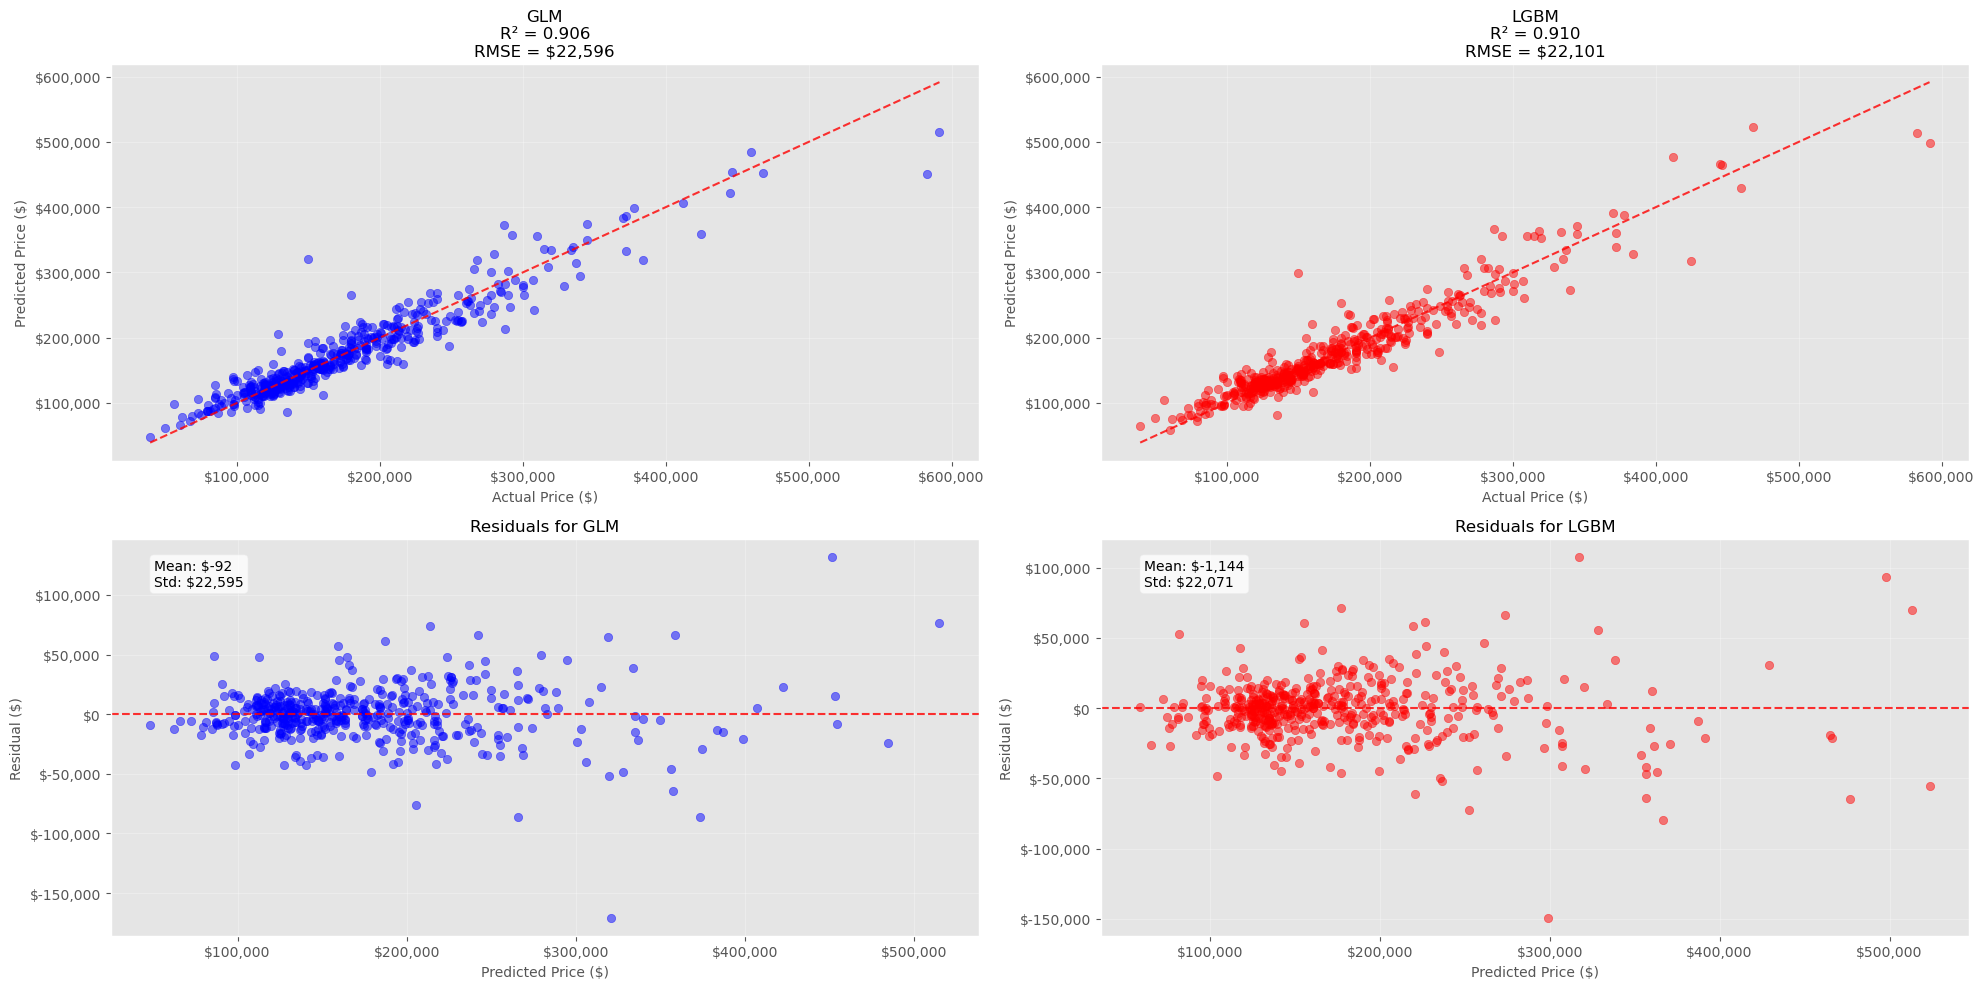

In [176]:
models = [glm_tuned_pipeline, lgbm_tuned_pipeline]
model_names = ['GLM', 'LGBM']

# Create and display the plot
plot = plot_predictions_and_residuals(
    models=models,
    X_test=X_test,
    y_test=y_test,
    model_names=model_names,
    figsize=(20, 10)
)
plot.show()

The model manages to keep track with the actual values very well, however, there are greater heteroskedasticity in the residuals at larger house values, this is because they are rarer and it would not be easier to capture.

# Model Diagnostics

In [205]:
glm_tuned_pipeline_exp = dx.Explainer(glm_tuned_pipeline, X_train, y_train, label = 'Tuned GLM with Interaction Terms',
                                      verbose=0)
lgbm_tuned_pipeline_exp = dx.Explainer(lgbm_tuned_pipeline, X_train, y_train, label = 'Tuned LGBM',
                                      verbose=0)

In [208]:
performance_glm = glm_tuned_pipeline_exp.model_performance()
performance_glm.plot()  # Overall performance metrics

In [206]:
# 1. Model Performance Diagnostics
performance_lgbm = lgbm_tuned_pipeline_exp.model_performance()
performance_lgbm.plot()  # Overall performance metrics

Y-axis (Percentage): Shows the percentage of predictions that have residuals larger than the corresponding x-axis value. 
X-axis (|residual|):
Shows the absolute size of prediction errors in dollars

Very few predictions (< 5%) have errors larger than $40k for LGBM, but it is the opposite for GLM.
The long tail to the right indicates some rare cases with very large errors (up to $120k) for GLM (DANGEROUS !). 

# Feature Importance

In [178]:
# 1. Feature Importance (Variable Importance)
feature_importance_glm = glm_tuned_pipeline_exp.model_parts()
feature_importance_glm.plot(show=True)
feature_importance_lgbm = lgbm_tuned_pipeline_exp.model_parts()
feature_importance_lgbm.plot(show=True)

SURPRISE SURPRISE ! Actually not, the top 5 most important features are `gr_liv_area`, `overall_score`, `interior_qu`, `age`, `total_bsmt_sf` and there is an agreement between the two models. This makes sense as the features are all related to the house size and quality. The age of the house at time sold clearly matters also for people's preference.
## Partial Dependence Plot

Let's focus on LGBM for now for the stylised notebook of key arguments.

In [179]:
numerical_important_features = ['gr_liv_area', 'age', 'total_bsmt_sf']
categorical_important_features = ['interior_qu', 'overall_score']

In [181]:
lgbm_tuned_pipeline_exp = dx.Explainer(lgbm_tuned_pipeline, X_train, y_train, label = 'Tuned LGBM',
                                      verbose=0)
pd_lgbm_tuned_pipeline_exp_categorical = lgbm_tuned_pipeline_exp.model_profile(variables = categorical_important_features, variable_type = 'categorical')
pd_lgbm_tuned_pipeline_exp_categorical.plot()
pd_lgbm_tuned_pipeline_exp_numerical = lgbm_tuned_pipeline_exp.model_profile(variables = numerical_important_features, variable_type = 'numerical')
pd_lgbm_tuned_pipeline_exp_numerical.plot()


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Calculating ceteris paribus: 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. We see that the large house (basement and ground area) consistently have an effect on price, but up to a point when it is as large enough, additional increase in area does not increase the price (same with age of the house, older houses decrease in values). 

Similarly, we get the very expected effect of higher quality overall and the values of its interiors, the higher the price. 

We added interaction terms in the GLM, so we will only look at the numerical features for the GLM.

In [182]:
pd_glm_tuned_pipeline_exp_numerical = glm_tuned_pipeline_exp.model_profile(variables = numerical_important_features, variable_type = 'numerical')
pd_glm_tuned_pipeline_exp_numerical.plot()

Calculating ceteris paribus: 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


Very same thing with LGBM, but a funny little return of the impact for age (as houses too old may then give back some value - like asthetics). 

However, we have to note that these features are correlated (like ground area and basement area), so the PDP will be biased

In [191]:
ale_lgbm_tuned_pipeline_exp_numerical = lgbm_tuned_pipeline_exp.model_profile(variables = numerical_important_features, variable_type = 'numerical', type='ale')
ale_lgbm_tuned_pipeline_exp_numerical.plot()


Calculating accumulated dependency: 100%|██████████| 3/3 [00:00<00:00, 41.78it/s]


    However, we can see that the ALE that corrects feature effect for feature dependence delivers the very same result as the PDP.

## Break Down Plot

In [192]:
breakdown = lgbm_tuned_pipeline_exp.predict_parts(X_train.iloc[0])
breakdown.plot(show=True)

This Break Down plot illustrates how various features influence the predicted price of a specific house (the first house in your training set). Here are the key elements:

- **Base Value (Intercept):** $181,270 - This is the initial prediction.
- **Positive Contributors (Green bars):**
    - **lot_frontage:lot_area (+$11,890):** The lot size has a significant positive impact.
    - **pct_unf_sf (+$3,257):** Unfinished space adds value.
    - **total_bsmt_sf (+$888):** The basement size contributes positively.
    - **exterior_1st being BrkFace (+$6,805):** A brick facade enhances value.
- **Negative Contributors (Red bars):**
    - **overall_score (-$9,329):** A lower overall score decreases the price.
    - **age (-$6,076):** An age of 50 years reduces the value.
    - **total_bath (-$5,634):** Having only one bathroom lowers the value.
    - **interior_qu (-$5,260):** An interior quality score of 14 decreases the value.
    - **neighborhood_score (-$4,520):** A neighborhood score of 11.09 reduces the value.
    - **exter_qu (-$2,521):** An exterior quality score of 1 decreases the value. (very bad outside haha)
- **Final Prediction:** $189,817

## Shapley Value

In [193]:
shap = lgbm_tuned_pipeline_exp.predict_parts(X_train.iloc[0], type='shap')
shap.plot(show=True)

The Shapley value method is based on Break Down predictions into parts. This is a slightly different approach than in the Break Down method. It is based on the idea of averaging the input value of a given variable overall or a large number of possible orders. 
Largest positive impact is the availability of lots, which is interesting as we remember it is a relatively rare feature. 
Note that overall score has a range from 2 to 19 so this is a negative impact for a house that is just roughly average in a relatively average neighborhood that discounts the impact that it has a LOT!

## Ceteris Paribus (CP) profiles

In [210]:
cp_profile = lgbm_tuned_pipeline_exp.predict_profile(X_train.iloc[0])
cp_profile.plot()

Calculating ceteris paribus: 100%|██████████| 22/22 [00:00<00:00, 402.49it/s]


The Ceteris Paribus profiles show how changing individual feature values affects the predicted house price while keeping all other features constant.  As expected, the most effect goes for quality and area of the houses, level of facilities and age. Clearly, univerisy proximity has very little response. Interestingly, in Iowa at least, there is some seasonality effect on the price of the houses, maybe people just get depressed in the winter and start selling their houses while winter is very cold and not very nice.